# A Deep Q-Network Implementation Step by Step

## Introduction
This notebook is a 'code-blog' entry describing and explaining an implementation of a Deep Q-Network (DQN) as studied in [Udacity's Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).  

We will go step by step and explain how and why each class and method is defined, how they work and finally how they all fit together as a workflow for implementing DQNs.  

If you are just getting started with DQNs, I suggest you start by checking out this [gitbook chapter](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/deep_q_learning.html). Once you have the basic ideas down, take the time to study Google Deepmind's [landmark paper on solving Atari videomages](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf), as well as the early precursor to it [Riedmiller 2005](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf).  

The particular implementation we are about to study is suitable for environments with continuous observation space and discrete action space, as found in openAI gym's [Box2D](https://gym.openai.com/envs/#box2d) classes of environment. If this terminology sounds like ancient greek to you, read openAI's documentation [here](http://gym.openai.com/docs/).  

## Troubleshooting Box2D environment imports
I and many others came across the following errors when attempting to import and generate Box2D environments from openAI gym:
```Python
env=gym.make('LunarLander-v2')
AttributeError: module 'gym.envs.box2d' has no attribute 'LunarLander-v2'```
```Building wheel for box2d-py (setup.py): finished with status 'error'
error: command 'swig.exe' failed: No such file or directory.```  

If you haven't, skip ahead. If you have, keep reading and I hope this helps.  

I think the **first error** is caused by not having Box2D environments installed within Jupyter Notebook, even if you have installed them in your Anaconda environment. [This blogpost](https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/) explains difficulties and differences between packages available to your environment vs those available to a Jupyter Notebook you deploy from that environment. The **second error** is a difficulty encountered once you get over the first one. If you succeed in running pip install from your notebook, you may run into the second set of errors if you don't have swig installed on your system, or if its location hasn't been added to System Environment variables.

If you run into these issues, the fix that worked for me was the following:
1. Use the following line to allow you to run pip installs from Jupyter ([source](https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/)), and perform a pip install of Box2D environments. This is the last line on the imports block of this notebook;
```Python
import sys
!{sys.executable} -m pip install gym[Box2D]```
2. Download swigwin from [this sourceforge link](http://prdownloads.sourceforge.net/swig/swigwin-4.0.1.zip), unzip it and copy the path (for example C:\swigwin-4.0.1, see [video if helpful](https://www.youtube.com/watch?v=HDD9QqLtAws)). Then add this path to your System Environment variables as shown: <img src="path.png" alt="Drawing" style="width: 600px;"/>  

3. Check that swig installed correctly: <img src="cmd.png" alt="Drawing" style="width: 400px;"/>  
4. Shut down the notebook, kill current Jupyter processes running in Anaconda with 2x ```Ctrl-C```, launch Anaconda and Jupyter again;
5. Run code block 1 (all the imports and pip install) and code block 2:
```Python
env = gym.make('LunarLander-v2')```
and that should instantiate any Box2D environment successfully.

That should work; if not, go over [this thread](https://github.com/openai/gym/issues/1603).

In [1]:
import numpy as np
import random
from collections import namedtuple, deque
import gym
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import sys
!{sys.executable} -m pip install gym[Box2D]

In [2]:
env = gym.make('LunarLander-v2')

C:\Users\Andre\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## The QNetwork class
Create the QNetwork class, which is an FC n-layered network with i) parameters for state size and action size, ii) parameters for number of units in each layer we wish to program, and 3) a method for forward propagation.

The line
```Python
super(QNetwork, self).__init__()```

is there because we are going to use QNetwork as a subclass of the parent class Agent. We want it to have both its parent class attributes (from Agent, which we will define shortly), as well as some other attributes which are specific to agents of type QNetwork but not other types of Agent.

In [3]:
class QNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        '''Initialise parameters and build the Q-network model.
        Arguments
        =========
            state_size (int): size of state space
            action_size (int): size of action space
            seed (int): random seed for replicability
            '''
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed) # Sets the seed for generating random numbers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Set up replay buffer size, minibatch size, discount factor gamma, soft update factor for w tau, learning rate and how often to update the local network. Then check if we have a GPU and cuda available and if so, get it ready to use.

In [4]:
buffer_size = int(1e5)
batch_size = 64
gamma = 0.99
tau = 1e-3
lr = 5e-4
update_every = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## The Agent class

### Agent attributes
To endow our Agent with its QNetwork 'brain', we set attributes qnetwork_local and qnetwork_target to be instances of the class QNetwork in the following lines:
```Python
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)```
Because we're using **Fixed Q Targets**, we actually set up two Q-networks: one which is the target we're trying to approximate and the other the current parameters for the approximation to the Q value function.

Here, we initialise the Agent's memory attribute, which is a collection of *experiences*, each of which is a tuple of form (state, action, reward, next_state).
```Python
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)```
And after it, we add a time-step counter.
### Agent methods: step
The step function,
```Python
        def step(self, state, action, reward, next_state, done):```
Takes in an experience tuple and adds it to the self.memory attribute of agent, as seen above. Then, it takes one time-step and checks if the number of time-steps after which to update (*update_every*) has been reached:
```Python
        self.t_step = (self.t_step + 1) % update_every```

If it has, *and* enough samples have been stored in memory (threshold defined by *batch_size*), it retrieves an experience tuple at random from memory and then passes it to the .learn method.
### Agent methods: act
*act* is the method for selecting an epsilon-greedy action given the current policy.  
First, we take the state and convert it from numpy to a pytorch tensor, unsqueeze it with 0(*returns a new tensor with a dimension of size one inserted at the specified position*) and send it to the same device where our QNetworks reside.

We then set the local QNetwork model to eval() mode. This pytorch method turns off dropout and batch normalisation. The reason for this is that in the next line,
```Python
        with torch.no_grad():
            action_values = self.qnetwork_local(state)```
   we are accessing the QNetwork final output values, by passing in a state and computing forward propagation through the QNetwork's current values. Dropout and batch normalisation are used for improving training and generalization, so here we wish to turn them off, in order to select an action. The code that follows is boilerplate for instantiating an epsilon-greedy action.

### Agent methods: learn
Here we update value parameters given a batch of experience tuples.  
First, we *detach* the target QNetwork from the computational graph, ensuring no gradient is backpropped along this network specifically. Then we obtain the maximum predicted Q values for next states from the target model:
```Python
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)```
Then, we use the Q-learning formula to compute Q-targets (approximation of true function) for current states that we're learning from. We next obtain the expected Q values from the local model, forward propping *states* through it and gather(ing) the results (think this is similar to zip).  
Next, we compute the loss, run backprop and update the local weights:
```Python
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()```  
Finally, we update the target QNetwork. Notice this is a different update from that executed on the local QNetwork. On the former, we're doing a 'real' learned update with gradient descent. On the latter we're using Fixed Q Targets through the *soft_update* function, which we'll look at next.
```Python
        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau)```
### Agent methods: soft update
Here the donkey has gotten close enough, so we move the carrot a little bit. The soft update goes by the formula
```θ_target = τ*θ_local + (1 - τ)*θ_target```, using tau as initialised at the top. The _ after copy is for making .copy an in-place method.

In [5]:
class Agent():
    
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-network 'brain'
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        # Optimizer - notice only used on local qnetwork
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        
        # Timestep counter
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        # Save the current experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn after every 'update_every' steps
        self.t_step = (self.t_step + 1) % update_every
        
        # if 'update_every' time steps have been reached (modulo division above),
        if self.t_step == 0:
                # and if there are enough samples in memory:
            if len(self.memory) > batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, gamma)
                
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval() # pytorch method for setting a network to evaluation (stop dropout and batchnorm)
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        loss = F.mse_loss(Q_expected, Q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau)
    
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## The ReplayBuffer class
Here we define ReplayBuffer which is an object with the ability to carry experiences up to a certain capacity (configured at the top, *buffer_size*).  
The attribute of ReplayBuffer which stores experiences is, appropriately, *self.memory*. We package experiences as named tuples in the self.experience attribute:
```Python
        self.experience = namedtuple("Experience", field_names=['state', 'action', 'reward', 'next_state', 'done'])```
Calling self.experience on data of the right format organises that data by returning a tuple of name 'Experience', with the fields defined and named above. 

### ReplayBuffer methods: add
.add takes in arguments for
```Python
        def add(self, state, action, reward, next_state, done):```
and passes them to self.experience for packaging. This experience is then appended to memory, up to the capacity *buffer_size*. Because *memory* is a deque, that means if it reaches capacity, the rule goes "new in, oldest out", where we can imagine elements getting added left to right. Once we reach capacity, if a new element is added (at the right), the oldest element falls off at the left end, and everything shifts one step left.

### ReplayBuffer methods: sample
From *memory* we sample a number *batch_size* of experiences at random, unpack them first into concatenated numpy arrays, converting them to pytorch and then sending them to the device (GPU) where we're doing computation.  
.sample returns tensors each containing:
```Python
        return (states, actions, rewards, next_states, dones)```

In [6]:
class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k = self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

## Training
Finally, we will build a function for controlling the agent-environment interaction, calling the functions and classes we have defined above appropriately. The algorithm created in this notebook can be used with environments that have continuous observation space and discrete action space.

### DQN function
We start out by defining a list of running scores and a deque (special list-like container with a max capacity then last-in-first-out bevaiour) to keep a windowed version of 100 scores, as well as initialising epsilon at a specified value.  
We then run a for loop for a given number of episodes, and within this we nest another for loop that defines a maximum length of timesteps for each episode. Let's break down the contents of this loop:
```Python
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break```
    1. agent.act computes the action values for a given input state and returns the epsilon-greedy action;
    2. Given the choice of action, env.step triggers a timestep in the environment, returning a new state, reward and a 'done' boolean.
    3. agent.step does a number of important things:
        3.1. First, it add's to the agent's memory the current state, action, reward, next_state and done variables;
        3.2. Then it updates the agent's timestep counter and checks if it's a multiple of *update_every*, the frequency of episodes over which we want the agent to do replay and offline learning;
        3.3. If that frequency has been reached *and* there are a certain number of experiences in the agent's memory, it calls the method sample() from the ReplayBuffer class to retrieve a *batch_size* number of experiences from memory.
        3.4. Finally it calls the Agent function *learn*, which does the following:
            3.4.1. Unpack each experience tuple into states, actions, rewards, next_state and one;
            3.4.2. Perform Q-learning  by obtaining the max Q value for the next state from the target model, compute the Q targets given the current state, and retrieve expected Q values given the current local model;
            3.4.3. Calculate loss, run backprop and update weights for the Local Q Network;
            3.4.4. Calls *soft_update* function to update Q in the Target Network, moving the target weights away from the current ones by a factor of tau.


At the end of an episode, we append that episode's score (running tally of reward) to scores and score_window and print the average of scores_window, which gives us the running average over the last 100 episodes. If we achieve the solve score, it prints this out and saves the model checkpoint. Finally, the function returns *scores*, the episode-by-episode running tally of scores attained.

In [7]:
def dqn(n_episodes = 2000, max_t=1000, eps_start=1.0, eps_decay=0.995, eps_end=0.01, solve_score=200.0):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
    
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_end*eps)

        print('\rEpisode {}\tAverage Score {:.2f}'.format(i_episode, np.mean(scores_window)), end='')
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=solve_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

# Putting it all together and in context
Before beginning to train our agent, let's take a birds-eye schematic view of how the parts of the whole implementation fit together, and what it all means in terms of our goal of training agents in continuous observation spaces.  

Often in Reinforcement Learning, problems are defined by finite Markov Decision Processes. In a model-free approach, the goal is, since we don't have access to the environment's one-step dynamics and therefore its true value function, to use a Monte Carlo or Temporal Difference approach to learn by experience. These methods allow us to reach optimal (or near-optimal) policies by over time, from experience, building a Q-table which takes the form of a lookup table specifying for each state what is the value of each action available to the agent. A policy can then be determined by given each state, searching for the action with the maximum value.  

This approach works very well if our observation space is finite, or discrete. A continuous observation space - which is the case for most situations in the real world - would require us to build an infinitely large Q lookup table. Therefore, to tackle continuous observation spaces with RL we can use two approaches: i) discretize the continuous space and use the same lookup-based method, or ii) use a range of methods to approximate the value function.  

**Deep Q Networks** are an approach where one uses deep learning and experience to learn a function Q'(s,a) which approximates Q(s,a) by using weight parameters. These parameters can be updated systematically towards a good solution by using gradient descent and a cost function which compares the value the network expected to receive for performing an action in a given state with the value it actually experienced.  

For more background, readers are directed to this [nice summary](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/deep_q_learning.html). In this particular implementation, we use two features which have been fundamental for the success and stability of deep learning-based approaches in RL: Experience Replay and Fixed Q targets.  

    - In **experience replay** we decouple experience from learning. During its interaction with the environment, due to reward contingencies the agent may learn to perform only a subset of actions which lead to it generating and experiencing a limited range of states over and over again. To avoid this, instead of learning & updating Q values online, the agent stores its experiences in memory and samples randomly from this memory to update Q values offline. This prevents the agent from learning only from highly correlated state-action-reward sequences. In fewer and snazzier words, experience replay allows us to reduce part of the RL value learning problem to supervised learning: we learn action *labels* (rewarded or not) online, but action *values* offline.  

    - With **fixed Q-targets** we try to solve the problem that in deep learning-based function approximation, the target we are trying to learn (good weight parameters that approximate the true value function) is the same as the set of parameters that we are modifying in order to reach it. This can create instability and prevent convergence of values towards an optimum. Using fixed Q-targets entails having 2 neural networks, a *target network* for generating target weight values in our road towards the optimal function, and a *local network* which is actually doing the learning. Every few trials we update using classical deep learning tools the local network's weights, based on how distant they are from the target network's weights. Then we shift the goalposts slightly, edging the target network weights away towards a new goal, which takes into account rewards received by the agent during an episode.  
    
Context and rationale given, how does all the code we've written above fit together?  

Below is a high-level schematic of the 'functional neuroanatomy' of the DQN implementation we've gone over in the notebook. We will go over this schematic at a high level to understand what's going on.    

<img src="dqn.jpg" width="800" />

The **Agent** has:

- 2 Neural networks (local and target), which are created by the class **QNetwork**. **QNetwork** does:
    - Creation of neural network objects of an architecture you specify in its arguments;
    - Forward propagation using state as input, if you call network(state).
- Memory, an object of class ReplayBuffer which is used to store experiences.  

The **Agent** does:
1. *Act*, by calling on **QNetwork** *forward* to obtain the values for each available action, then running its own code to pick an epsilon-greedy action
2. *Step*, by calling:
    - 2.1. Class **ReplayBuffer**'s *add* method, which takes argument *buffer size* and ReplayBuffer's *experience* attribute. The former determines how much memory capacity our agent has. The latter calls on the namedtuple method to package an episode's state, action, reward, next_state and done into a tuple called *experience*. This is appended into *Memory*, which is a container of type ReplayBuffer and an attribute of Agent, with capacity for a number *buffer size* of *experiences*.
    - 2.2. **Class ReplayBuffer**'s *sample* method, which takes argument *batch size* to determine how many *experiences* stored in *memory* to recall and use during a learning step.
    - 2.3. The Agent's Learn method,
3. *Learn*, by calling:
     - 3.1. **QNetwork**'s forward method to compute the max predicted Q values for the target model, and the expected Q values from the local model. *Learn* uses its own code to compute Q targets that the current state is trying to learn
     - 3.2. Loss, backward and optimise PyTorch methods to perform gradient descent, backpropagation and weight updating for the local **QNetwork**
     - 3.3. The Agent's Soft Update method,
4. *Soft update*, which moves our fixed Q target weight parameters by quantity tau, operating on the weights of target **QNetwork**, previously excluded from gradient-based updating.

In [10]:
env.seed(0)
s = env.observation_space.shape[0]
a = env.action_space.n

agent = Agent(state_size=s, action_size=a, seed=0)
scores = dqn(n_episodes = 5000)

Episode 100	Average Score: -231.16
Episode 200	Average Score: -126.86
Episode 300	Average Score: -96.39
Episode 400	Average Score: -108.00
Episode 500	Average Score: -70.62
Episode 600	Average Score: -22.88
Episode 700	Average Score: -14.95
Episode 800	Average Score: 86.50
Episode 899	Average Score 200.61
Environment solved in 799 episodes!	Average Score: 200.61


## Visualize
Training is now completed. Hopefully the agent managed to solve the task, or at least learn something useful. In the next two codeblocks we plot the agent's score per episode and then watch our trained agent perform a few trials. Change how many episodes you wish to visualise and how many frames per episode to render by toggling the variables at the top of the last codeblock.

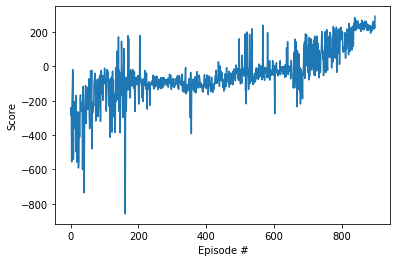

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

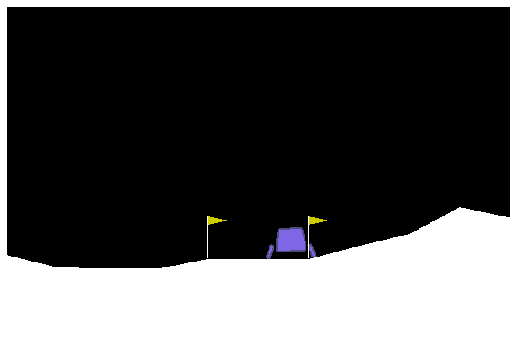

In [12]:
# render a few episodes to watch our trained agent perform the task
torender_episodes = 3
torender_frames = 300

plt.figure(figsize=(9,9))

for i in range(torender_episodes):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(torender_frames):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 

env.close()

# The End
And that's a wrap. I find writing these code blogs extremely useful for my studies in RL and AI in general. I am not a fast learner and much like an agent with Experience Replay, I find it useful to pause lectures and work through implementations and material at my own pace, aiming for a deep level of understanding.  

As disclaimed in the repo's readme, the comments and interpretations offered in this notebook are correct only to the extent of my knowledge at the time of writing them. If you find something that I got wrong, do get in touch and you'd be doing me a big favour if you helped me correct it.  

If you found this useful in your own studies, I'd love to know. **Say hi to me on [twitter](https://twitter.com/TheFrontalLobe_) or [linkedin](https://www.linkedin.com/in/andre-marques-smith/)**!